<a href="https://colab.research.google.com/github/danielka223/ds_workshop/blob/master/dsWorkshopAmazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="left">Helpfulness Prediction of Amazon Product Reviews</h1> 
<h2 align="left">DS Workshop - Fall 18/19 - Tel Aviv University</h2> 
<h3 align="left">By Daniel K.A, Ido Salomon, Itamar Mutzafi and Sagi Aharoni</h3> 




#Notebook Initialization
This section should only run once on a new runtime

In [0]:
#@title Install Required Packages

!pip install wordcloud

In [0]:
#@title Import Python Libraries {display-mode: "form"}

import os
import glob
import pandas as pd
import json
import datetime

from google.colab import drive

from contextlib import contextmanager
from os.path import getsize, basename
from tqdm import tqdm

import requests
import re

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

import gzip

In [0]:
#@title Connect to Drive {display-mode: "form"}

drive.mount('/content/drive/')
            

In [0]:
#@title Infra Definitions

@contextmanager
def pbopen(filename, mode='r'):
    total = getsize(filename)
    pb = tqdm(total=total, unit="B", unit_scale=True,
              desc=basename(filename), miniters=1,
              ncols=80, ascii=True)

    def wrapped_line_iterator(fd):
        processed_bytes = 0
        for line in fd:
            processed_bytes += len(line)
            # update progress every MB.
            if processed_bytes >= 1024 * 1024:
                pb.update(processed_bytes)
                processed_bytes = 0

            yield line

        # finally
        pb.update(processed_bytes)
        pb.close()

    with open(filename, mode) as fd:
        yield wrapped_line_iterator(fd)
        
#decompress input folder to output folder
def ungzip(source_dir, dest_dir):
  for src_name in glob.glob(os.path.join(source_dir, '*.gz')):
      base = os.path.basename(src_name)
      dest_name = os.path.join(dest_dir, base[:-3])
      with gzip.open(src_name, 'rb') as infile:
          with open(dest_name, 'wb') as outfile:
              for line in infile:
                  outfile.write(line)

In [0]:
#@title Data Fetching

# the following script downloads the Amazon Review Dataset into google drive

root = "drive/Team Drives/DS Workshop/data/"
compressed_path = root + "compressed/"

#uncomment to download
review_paths = [
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Wireless_v1_00.tsv.gz"
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Watches_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_DVD_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Toys_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Tools_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Sports_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Software_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Shoes_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Pet_Products_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_PC_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Outdoors_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Office_Products_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Musical_Instruments_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Music_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Mobile_Apps_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Major_Appliances_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Luggage_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Lawn_and_Garden_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Kitchen_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Jewelry_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Home_Improvement_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Home_Entertainment_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Home_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Health_Personal_Care_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Grocery_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Gift_Card_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Furniture_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Music_Purchase_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Ebook_Purchase_v1_01.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Ebook_Purchase_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Camera_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Books_v1_02.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Books_v1_01.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Books_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Beauty_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Baby_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Automotive_v1_00.tsv.gz",
#                 "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz",
               ]

#download dataset for each category, store in drive
for url in review_paths:
  print("starded downloading " + url)
  category = re.search('us_(.+?)_v1', url).group(1)
  file_path = compressed_path + category + ".tsv.gz"
  r = requests.get(url, allow_redirects=True)
  open(file_path, 'wb').write(r.content)
  print("finished downloading " + url)

#unzip datasets  
#ungzip(compressed_path, root)

# Data Collection


In [0]:
#@title Data Filters

include_all_categories = True #@param {type:"boolean"}
pick_category = "Shoes"  #@param ['Apparel', 'Automotive', 'Baby', 'Beauty', 'Books', 'Books_v1_00', 'Books_v1_01', 'Camera', 'Digital_Ebook_Purchase', 'Digital_Ebook_Purchase1', 'Digital_Music_Purchase', 'Digital_Software', 'Digital_Video_Download', 'Digital_Video_Games', 'Electronics', 'Furniture', 'Gift_Card', 'Grocery', 'Health_Personal_Care', 'Home', 'Home_Entertainment', 'Home_Improvement', 'Jewelry', 'Kitchen', 'Lawn_and_Garden', 'Luggage', 'Major_Appliances', 'Mobile_Apps', 'Mobile_Electronics', 'Music', 'Musical_Instruments', 'Office_Products', 'Outdoors', 'PC', 'Personal_Care_Appliances', 'Pet_Products', 'Shoes', 'Software', 'Sports', 'Tools', 'Toys', 'Video', 'Video_DVD', 'Video_Games', 'Watches', 'Wireless']
entry_limit = 1000  #@param {type: "slider", min: 1000, max: 5000000, step:1000}
#@markdown ---
#@markdown ###Review Filters
filter_reviews_older_than = '2010-11-05'  #@param {type: "date"}

#generate ds paths
root = "drive/Team Drives/DS Workshop/data/"
file_ext = ".tsv"
ds_path = root + pick_category + file_ext

file_names = glob.glob1(root, "*" + file_ext)
all_paths = [root + filename for filename in file_names]

In [0]:
if include_all_categories:
  ds_list = []
  for path in all_paths:
    cat_ds = pd.read_csv(path, 
                        delimiter='\t',
                        warn_bad_lines=True,
                        error_bad_lines=False,
                        nrows=entry_limit)
    ds_list.append(cat_ds)
    reviews = pd.concat(ds_list, axis = 0, ignore_index = True)
else:
  reviews = pd.read_csv(ds_path, 
                        delimiter='\t',
                        warn_bad_lines=True,
                        error_bad_lines=False,
                        nrows=entry_limit)

reviews['unhelpful_votes'] = reviews['total_votes'] - reviews['helpful_votes']
thumbs = pd.DataFrame(reviews.groupby('customer_id').mean())
thumbs = thumbs[['helpful_votes','unhelpful_votes']]
thumbs.columns = ['helpful_votes_avg','helpful_votes_avg']
commentCount=pd.DataFrame(reviews.groupby('customer_id').size())
commentCount.columns=['commentCount']
reviews = reviews.join(commentCount, on='customer_id').join(thumbs, on='customer_id')
reviews.describe()

b'Skipping line 88: expected 15 fields, saw 22\n'


,customer_id,product_parent,star_rating,helpful_votes,total_votes,unhelpful_votes,commentCount,helpful_votes_avg,helpful_votes_avg
count,4.600000e+04,4.600000e+04,46000.000000,46000.000000,46000.000000,46000.000000,46000.000000,46000.000000,46000.000000
mean,2.547655e+07,5.011036e+08,4.219391,1.057935,1.431457,0.373522,2.191696,1.057935,0.373522
std,1.633646e+07,2.891414e+08,1.287225,10.082866,11.352997,2.627766,3.813438,9.363677,2.575904
min,1.062600e+04,5.317700e+04,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.231616e+07,2.524672e+08,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,2.355229e+07,4.937118e+08,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,4.100198e+07,7.547911e+08,5.000000,0.000000,1.000000,0.000000,2.000000,0.500000,0.000000
max,5.309637e+07,9.999939e+08,5.000000,1150.000000,1228.000000,265.000000,68.000000,1150.000000,265.000000


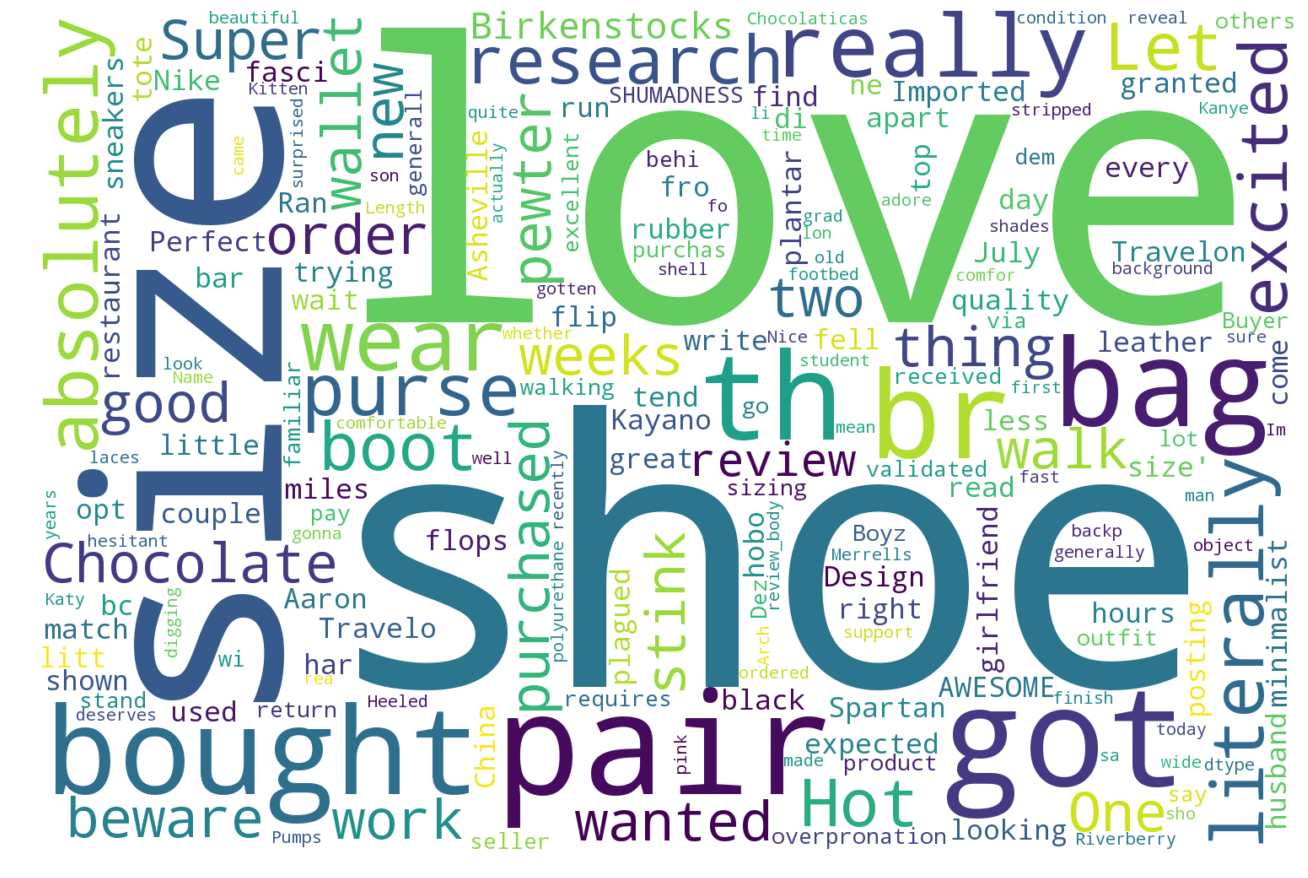

In [0]:
#wordcloud
text = reviews['review_body']
wordcloud = WordCloud(
    width = 1500,
    height = 1000,
    background_color = 'white',
    ).generate(str(text))
fig = plt.figure(
    figsize = (18, 12),
    facecolor = 'w',
    edgecolor = 'w')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()